# MILESTONE 12
## Decorrelación temporal en señales de audio
Raquel Gutiérrez García

José Francisco Martos García


# Cambios en DWT_analyze y DWT_syntethise
- La variable `slices` no es tan variable (decidimos guardarlo en una variable de la clase `Temporal_decorrelation`)
- Uso de `pywt.ravel_coeffs()` en lugar de `pywt.coeffs_to_array()` para simplificar el proceso de serializado

# COMPARATIVA DE EFICIENCIA EN EL DOMINIO RD
## ¿Cómo hemos decidido hacerlo?
Compararemos todas las wavelets que aparecen en la página [wavelets.pybytes.com](http://wavelets.pybytes.com/). 

En este Jupyter, se comprueban los mismos 6 audios para cada wavelet (se pueden añadir los que queramos), en principio tenemos los siguientes tipos de audios con lo que nos gustaría que funcione bien nuestro programa:
- Silencio
- Voz
- Ruido
- Ruido con voz
- Pitido
- Pitido con voz

Para cada wavelet sería:

 ![Comparativa DWT db19](https://raw.githubusercontent.com/RaquelGG/TM/39614d707029221a4f063455c679a045cf40aae9/otros/DWT-db19.svg)

Hacemos la media elemento a elemento con [`numpy.mean(array, axis=0)`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html):

![Comparativa DWT db19 Media](https://raw.githubusercontent.com/RaquelGG/TM/69bc3757eb4b040c741e4a59e483465bcfeaa228/otros/DWT-db19-media.svg)

Y cuando se comparen diferentes wavelets y saber cuál es la menor, calculamos el área debajo de la curva para cada una y escogemos la menor, para esto usamos [`numpy trapz`](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html).

![DWT-db19-media-area-bajo-la-curva](https://raw.githubusercontent.com/RaquelGG/TM/master/otros/area_bajo_curva.png)

En este caso, el área debajo de la curva es de 23.36 unidades²

Para cada familia de wavelets cogeremos el de menor área y luego compararemos los mejores de cada familia de wavelets.


In [1]:
import common
import sounddevice as sd
import numpy as np
import pywt
from common import plot, average_energy, RMSE, entropy_in_bits_per_symbol, RD_curve, q_deq
from br_control import Quantization
from stereo_decorrelate import Stereo_decorrelation
from temporal_decorrelate import Temporal_decorrelation

%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from numpy import trapz

In [50]:
fs = 44100
duration = 3.0  # seconds
x = [] # [0] - silencio, [1] - voz, [2] - ruido, [3] - ruido con voz, [4] - pitido, [5] - pitido con voz

Habla!
[COMPLETO]


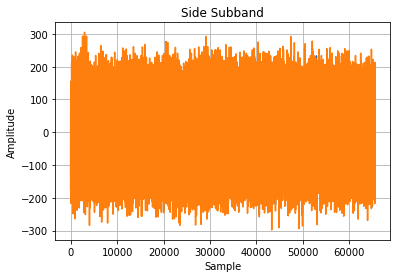

In [56]:
x.append(sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)[:65536])
print("Habla!")
while sd.wait():
    pass
print("[COMPLETO]")
plot(rec, xlabel="Sample", ylabel="Amplitude", title="Side Subband")

In [75]:
nombres_audio = ["silencio", "voz", "ruido", "ruido con voz", "pitido", "pitido con voz"]
for i in range(len(x)):
    sd.play(x[i]) # silencio
    print("Reproduciendo", nombres_audio[i])
    while sd.wait():
        pass
    print("[COMPLETO]")

Reproduciendo silencio
[COMPLETO]
Reproduciendo voz
[COMPLETO]
Reproduciendo ruido
[COMPLETO]
Reproduciendo ruido con voz
[COMPLETO]
Reproduciendo pitido
[COMPLETO]
Reproduciendo pitido con voz
[COMPLETO]


In [61]:
stereo_dec = Stereo_decorrelation()
temporal_dec = Temporal_decorrelation()

def DWT_RD_curve(data, levels, wavelet):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = stereo_dec.MST_analyze(data)
        DWT_coefs = temporal_dec.DWT_analyze(MST_coefs, levels, wavelet)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k)
        MST_coefs = temporal_dec.DWT_synthesize(y, wavelet)
        reconstructed_data = stereo_dec.MST_synthesize(MST_coefs)

        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [62]:
levels = 5

# Minimo de cada Wavelet
min_names = []


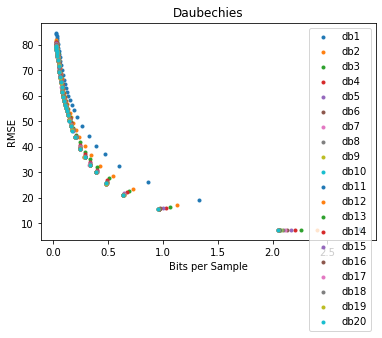

db19


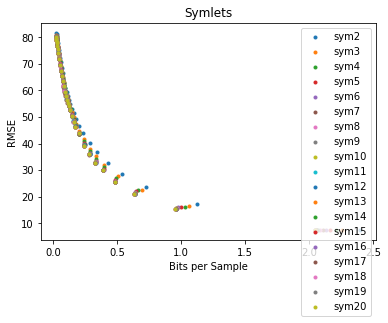

sym16


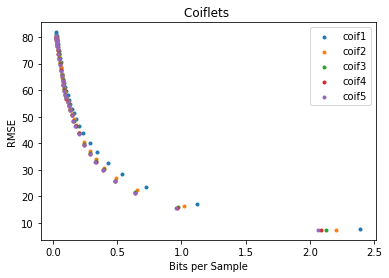

coif5


In [63]:
wavelets = [["Daubechies", "db", 1, 21], ["Symlets", "sym", 2, 21], ["Coiflets ", "coif", 1, 6]]

for w in wavelets:
    minimo = 1000000
    nombre_minimo = ""

    plt.title(w[0])
    plt.xlabel("Bits per Sample")
    plt.ylabel("RMSE")

    # w[0] - Nombre de la Wavelet
    # w[1] - Abreviatura
    # w[2] - Dónde empieza
    # w[3] - Dónde acaba
   
    for i in range(w[2], w[3]):
        DWT_RD_points = []
        for rec in x:
            DWT_RD_points.append(DWT_RD_curve(rec, levels, pywt.Wavelet(w[1] + str(i))))
        average_dwt_rd_points = np.mean(DWT_RD_points, axis=0)
        plt.scatter(*zip(*average_dwt_rd_points), marker=".", label=w[1] + str(i))
        
        area_bajo_curva = trapz(average_dwt_rd_points[0], dx=5)
        if minimo > area_bajo_curva:
            minimo = area_bajo_curva
            nombre_minimo = w[1] + str(i)

    plt.legend(loc='upper right')
    plt.show()
    print(nombre_minimo)
    min_names.append(nombre_minimo)

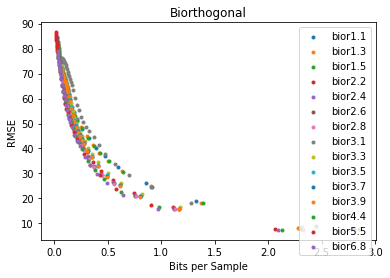

bior6.8


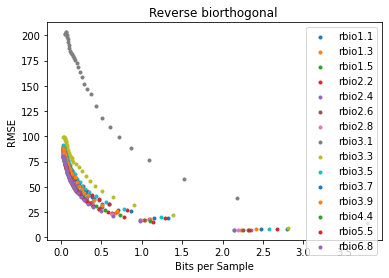

rbio6.8


In [64]:
numeros = ["1.1", "1.3", "1.5", "2.2", "2.4", "2.6", "2.8", "3.1", "3.3", "3.5", "3.7", "3.9", "4.4", "5.5", "6.8"]
wavelets_o = [["Biorthogonal", "bior"], ["Reverse biorthogonal ", "rbio"]]

for w in wavelets_o:
    minimo = 1000000
    nombre_minimo = ""

    plt.title(w[0])
    plt.xlabel("Bits per Sample")
    plt.ylabel("RMSE")

    # w[0] - Nombre de la Wavelet
    # w[1] - Abreviatura
    # w[2] - Dónde empieza
    # w[3] - Dónde acaba
   
    for i in numeros:
        DWT_RD_points = []
        for rec in x:
            DWT_RD_points.append(DWT_RD_curve(rec, levels, pywt.Wavelet(w[1] + str(i))))
        average_dwt_rd_points = np.mean(DWT_RD_points, axis=0)
        plt.scatter(*zip(*average_dwt_rd_points), marker=".", label=w[1] + str(i))
        
        area_bajo_curva = trapz(average_dwt_rd_points[0], dx=5)
        if minimo > area_bajo_curva:
            minimo = area_bajo_curva
            nombre_minimo = w[1] + str(i)

    plt.legend(loc='upper right')
    plt.show()
    print(nombre_minimo)
    min_names.append(nombre_minimo)

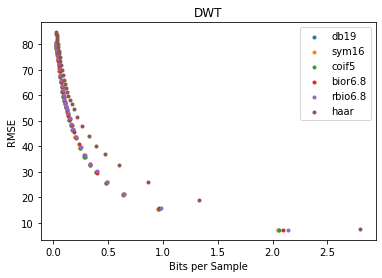

El mejor resultado ha sido  db19


In [65]:
plt.title("DWT")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")


min_names.append("haar")
# min_names.append("dmey") # resultados muy malos
minimo = 1000000
nombre_minimo = ""

for wavelet_name in min_names:
    DWT_RD_points = []
    for rec in x:
        DWT_RD_points.append(DWT_RD_curve(rec, levels, pywt.Wavelet(wavelet_name)))
    average_dwt_rd_points = np.mean(DWT_RD_points, axis=0)
    plt.scatter(*zip(*average_dwt_rd_points), marker=".", label=wavelet_name)
    
    area_bajo_curva = trapz(average_dwt_rd_points[0], dx=5)
    if minimo > area_bajo_curva:
        minimo = area_bajo_curva
        nombre_minimo = wavelet_name

plt.legend(loc='upper right')
plt.show()

print("El mejor resultado ha sido ", nombre_minimo)

## Comparación entre br_control.py, stereo_decorrelate.py y temporal_decorrelate.py

In [71]:
def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = stereo_dec.MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = stereo_dec.MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

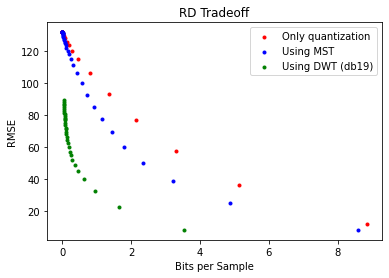

In [73]:
q_RD_points = q_RD_curve(x[3])
MST_RD_points = MST_RD_curve(x[3])
DWT_RD_points = DWT_RD_curve(x[3], levels, pywt.Wavelet(nombre_minimo))

plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='Only quantization')
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='Using MST')
plt.scatter(*zip(*DWT_RD_points), c='g', marker=".", label=f"Using DWT ({nombre_minimo})")
plt.legend(loc='upper right')
plt.show()